## Setup

In [1]:
# Imports
import math, random, torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import ConfusionMatrix
from torch.utils.data import TensorDataset, DataLoader

# Custom Import
from multihead_attention import MultiheadAttention

In [2]:
BATCH_SIZE = 8
SEQ_LEN = 16
NHEAD = 8
EMBED_SIZE = 512
DEVICE = "cuda"
model = MultiheadAttention(EMBED_SIZE, NHEAD, device=DEVICE).to(DEVICE)

## Run Model (Forward Pass)

In [3]:
X = torch.rand(BATCH_SIZE, SEQ_LEN, EMBED_SIZE).to(DEVICE) # (Batch Size, Seq. Len., Embed Size)
Q, K, V = X, X, X # Queries, Keys and Values are the same for non-translation
attn_output, attn_output_weights = model(Q, K, V)
print(f"Attention Output: {attn_output.shape}")
print(f"Attention Weights: {attn_output_weights.shape}")

Attention Output: torch.Size([8, 16, 512])
Attention Weights: torch.Size([64, 16, 16])


## Attention Weights

<Axes: >

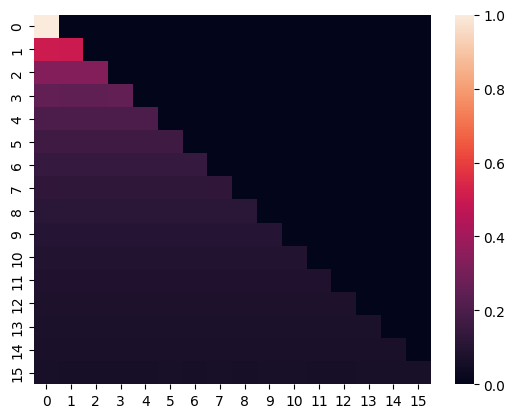

In [4]:
sns.heatmap(torch.mean(attn_output_weights, dim=0).detach().cpu().numpy())

## Mask

In [5]:
# Get a standard mask from class function
mask = model.get_mask(X).to(DEVICE)
print(mask.shape)
mask = mask.repeat(model.nheads, 1, 1)
print(mask.shape)

torch.Size([8, 16, 16])
torch.Size([64, 16, 16])


## Creating Attention Inputs

In [6]:
# Create Q, K, V matrices and reshape
bsz, tgt_len, _ = X.shape
x = model.linear_q(X)
print(x.shape)
x = model.activation(X)
print(x.shape)
x = x.view(tgt_len, bsz * model.nheads, model.head_dim).transpose(0, 1)
print(x.shape)

torch.Size([8, 16, 512])
torch.Size([8, 16, 512])
torch.Size([64, 16, 64])


## The Attention Equation

In [7]:
# Apply attention - Part 1
x_scaled = x * math.sqrt(1.0 / float(model.embed_size))
attn_output_weights = torch.baddbmm(
    mask, x_scaled, x.transpose(-2, -1)
)
attn_output_weights = F.softmax(attn_output_weights, dim=-1)
attn_output = torch.bmm(attn_output_weights, x)
print(attn_output.shape)
attn_output = (
    attn_output.transpose(0, 1).contiguous().view(tgt_len * bsz, model.embed_size)
)
print(attn_output.shape)

torch.Size([64, 16, 64])
torch.Size([128, 512])


## Post-Attention Linear Layer

In [8]:
# Apply attention - Part 2
attn_output = model.linear_o(attn_output)
print(attn_output.shape)
attn_output = model.activation(attn_output)
print(attn_output.shape)
attn_output = attn_output.view(bsz, tgt_len, model.embed_size)
print(attn_output.shape)

torch.Size([128, 512])
torch.Size([128, 512])
torch.Size([8, 16, 512])


## Create a Dataset to Test the Model

In [9]:
# Fibonacci Numbers
def fibonacci(x):
    v1=0
    v2=1
    result = [None]*x
    for i in range(x):
        next_val = v1 + v2
        result[i] = v1
        v1 = v2
        v2 = next_val
    return result

# Lucas numbers
def lucas(x):
    result = [None]*x
    fib = fibonacci(x+2)
    for i in range(1, x+1):
        result[i-1] = fib[i-1] + fib[i+1]
    return result


# Squares
def squares(x):
    result = [xx**2 for xx in range(x)]
    return result

# Get Sequences
SS = 4
MAX = 20
fib = fibonacci(MAX)
luc = lucas(MAX)
sqr = squares(10*MAX)

# Generate Data
N = 200
X, Y = [], []
for n in range(N):
    seq = random.randint(0, 2)
    idx = random.randint(0, MAX-SS-1)
    if seq==0: X.append(fib[idx:idx+SS])
    elif seq==1: X.append(luc[idx:idx+SS])
    elif seq==2: X.append(sqr[idx:idx+SS])
    Y.append([0, 1] if seq==0 else [1, 0])

## Create A Model with Data Embedding

In [10]:
# Multihead Attention Modulde
class TestModel(nn.Module):

    def __init__(self,
                 max_len,
                 max_embed,
                 embed_size,
                 nheads,
                 num_classes = 2,
                 device="cpu",
                 activation=F.relu):
        super(TestModel, self).__init__()
        self.embed_size = embed_size
        self.embedding = nn.Embedding(max_embed, embed_size)
        self.multihead = MultiheadAttention(embed_size, nheads, activation, device)
        self.conv_out = nn.Conv1d(max_len, 1, kernel_size=3, padding=1)
        self.linear = nn.Linear(embed_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, q, k, v):
        q, k, v = self.embedding(q), self.embedding(k), self.embedding(v)
        attn_output, attn_output_weights = self.multihead(q, k, v)
        x = self.conv_out(attn_output)
        x = x.reshape(-1, self.embed_size) 
        x = self.linear(x)
        x = self.softmax(x)
        return x, attn_output_weights

## Training Loop

In [11]:
DEVICE = "cuda"
EPOCHS = 200
BATCH_SIZE = 1
EMBED_SIZE = 512
LEARNING_RATE = 4.12E-5
test_model = TestModel(max_len=SS, 
                       max_embed=np.max(X)+1, 
                       embed_size=EMBED_SIZE, 
                       nheads=4,
                       device=DEVICE).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(test_model.parameters(), lr=LEARNING_RATE)
train_dataset = TensorDataset(torch.Tensor(X).type(torch.LongTensor).to(DEVICE), 
                        torch.Tensor(Y).to(DEVICE))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

for epoch in range(EPOCHS):
    test_model.train()
    train_loss = 0
    for xx, yy in train_dataloader:
        optimizer.zero_grad()
        out, attn_weights = test_model(xx, xx, xx)
        loss = criterion(out, yy)
        train_loss = train_loss + loss.item()
        loss.backward()
        optimizer.step()

print(f"Final Loss: {train_loss}")

c:\Users\kril\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Final Loss: 62.6523494720459


In [12]:
x = torch.Tensor(X).type(torch.LongTensor).to(DEVICE)
y = torch.Tensor(Y).to(DEVICE)
y_hat, _ = test_model(x, x, x)
yam = torch.argmax(y.detach().cpu(), dim=1)
yham = torch.argmax(y_hat.detach().cpu(), dim=1)
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat(yham, yam)

tensor([[136,   5],
        [ 17,  42]])

In [13]:
166/200

0.83

<Axes: >

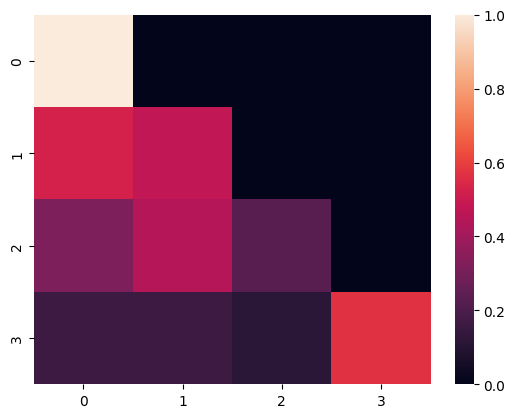

In [14]:
sns.heatmap(torch.mean(attn_weights, dim=0).detach().cpu().numpy())